In [1]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import matplotlib.pyplot as plt
%matplotlib inline

## Cluster setup

In [2]:
from dask_kubernetes import KubeCluster

In [3]:
cluster = KubeCluster(n_workers=10)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.33.233.2:40283
distributed.scheduler - INFO -   dashboard at:                     :8787


In [4]:
from dask.distributed import Client
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-59c01894-3edd-11eb-811f-5e2d7da37d30
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.233.2:40283 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.33.240.3:43497
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.240.3:43497
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.241.3:46043
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.241.3:46043
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.234.3:41515
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.234.3:41515
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.236.3:39573
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.236.3:39573
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.227.4:40371
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.227.4:40371
distributed.c

## Data setup

In [5]:
storage_path = 'ag1000g-release/phase1.AR3/variation/main/zarr/ag1000g.phase1.ar3'

# GCS configuration
import gcsfs
gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)


In [6]:
callset = zarr.open_consolidated(store)
callset

<zarr.hierarchy.Group '/'>

In [7]:
chrom = '3R'

In [8]:
gtz = callset[chrom]['calldata/GT']
gtz

<zarr.core.Array '/3R/calldata/GT' (22632425, 765, 2) int8>

In [9]:
# gtz.info

In [10]:
gt = allel.GenotypeDaskArray(gtz)
gt

<GenotypeDaskArray shape=(22632425, 765, 2) dtype=int8>

In [11]:
!wget --no-clobber ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/samples/samples.meta.txt

File ‘samples.meta.txt’ already there; not retrieving.


In [12]:
df_samples = pd.read_csv('samples.meta.txt', sep='\t')
df_samples.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


## Subset data

In [13]:
pop = 'BFS'

In [14]:
loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
loc_pass_variants

array([False, False, False, ..., False, False, False])

In [15]:
len(loc_pass_variants), np.count_nonzero(loc_pass_variants)

(22632425, 13167162)

In [16]:
loc_pop_samples = df_samples[df_samples.population == pop].index.values
loc_pop_samples

array([  0,  14,  15,  22,  23,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  92,  95,
       103, 105, 106, 108, 109, 111, 112, 114, 117, 121, 122, 123, 124,
       127, 128, 131, 132, 135, 136, 137, 138, 139, 140, 142, 143, 145,
       146, 148, 149])

In [17]:
len(loc_pop_samples)

81

In [18]:
gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
gt_pass_pop

<GenotypeDaskArray shape=(13167162, 81, 2) dtype=int8>

## Allele count computation

In [19]:
# watch the dask dashboard while this is computing
ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3).compute()
ac_pass_pop

<AlleleCountsArray shape=(13167162, 4) dtype=int32>
162   0   0   0
161   1   0   0
162   0   0   0
...
162   0   0   0
155   7   0   0
159   3   0   0

In [20]:
ac_pass_pop.count_segregating()

5755380

## Multi-population test for selection

In [21]:
def population_allele_counts(chrom, pop):
    gtz = callset[chrom]['calldata/GT']
    gt = allel.GenotypeDaskArray(gtz)
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    loc_pop_samples = df_samples[df_samples.population == pop].index.values
    print(pop, 'no. samples:', len(loc_pop_samples))
    gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
    ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3)
    return ac_pass_pop


def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = population_allele_counts(chrom, pop1).compute()
    ac2 = population_allele_counts(chrom, pop2).compute()
    ac3 = population_allele_counts(chrom, pop3).compute()
#     ac1, ac2, ac3 = da.compute(ac1, ac2, ac3)
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    ac3 = allel.AlleleCountsArray(ac3)
    print('finished allele counting')

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    print('found', np.count_nonzero(loc_seg), 'segregating variants')
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    print('finished locating segregating variants')
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)
    print('finished computing PBS')

    return starts, ends, res


In [22]:
# watch the dask dashboard
starts, ends, y = pbs('3R', 'BFS', 'UGS', 'GWA')

BFS no. samples: 81
UGS no. samples: 103
GWA no. samples: 46
finished allele counting
found 1450994 segregating variants
finished locating segregating variants
finished computing PBS


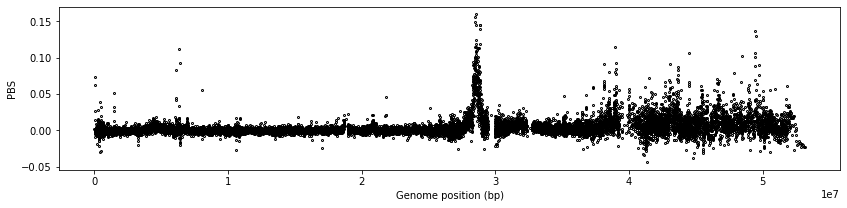

In [23]:
fig, ax = plt.subplots(figsize=(14, 3))
x = (starts + ends) / 2
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_ylabel('PBS');